## background 
- 32% survival
- women,children,upper class more likely survived
- not enough boats

## load utils

In [1]:
import sys
sys.path.append('../')
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from util import *
from onehot import LabelBinarizerEx
from pipeline import FeaturePipeline, DataFramePipeline
from binning import Binner
from title import TitleExtractor
from cabin import HasCabin
from ensemble import EnsembleStackClassifierEx
from addcols import AddColumns
from impute import GroupImputer,MixImputer
from alone import IsAlone
from scipy.stats import boxcox
import pandas as pd



d:\app\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load train data

In [2]:
passenger_train=pd.read_csv('raw_data/train.csv')
passenger_test=pd.read_csv('raw_data/test.csv')
target_col='Survived'
id_col='PassengerId'
target=passenger_train[target_col]
total_num=len(passenger_train)

In [3]:
passenger_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
passenger_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
passenger_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
passenger_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Renouf, Mrs. Peter Henry (Lillian Jefferys)",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [7]:
passenger_test.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Carver, Mr. Alfred John",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [8]:
raw_df=pd.concat([passenger_train.drop(target_col,axis=1),passenger_test]).drop(id_col,axis=1)
raw_df.index=np.arange(len(raw_df))
org_cols=raw_df.columns

age_group=raw_df.groupby(['Pclass','Sex']).mean()['Age']
missing_index=raw_df[raw_df.Age.isnull()].index
for i in missing_index:
    raw_df.loc[i,'Age'] = age_group[(raw_df.loc[i,'Pclass'],raw_df.loc[i,'Sex'])]
    
raw_df.Fare=Imputer(strategy='mean').fit_transform(raw_df.Fare.values.reshape(-1,1))

raw_df['FamilySize']=raw_df.SibSp+raw_df.Parch

raw_df['IsAlone']=(raw_df.FamilySize==0).astype('int')

for c in ['Pclass','Age','Fare','SibSp','Parch','FamilySize']:
    new_c=c+'_Norm'
    raw_df[new_c]=raw_df[c]
    if raw_df[new_c].min()<=0.:
        raw_df[new_c]=raw_df[new_c]+abs(raw_df[new_c].min())+0.1
    tranformed,_=boxcox(raw_df[new_c])
    raw_df[new_c]=StandardScaler().fit_transform(tranformed.reshape(-1,1))
import re

# def extractTitle(name):
#     m = re.search(' \w+\\.',name)
#     if m:
#         return m.group()[1:-1]
#     else:
#         return np.nan
    
def extractTitle(name):
    title=np.nan
    m = re.search(' \w+\\.',name)
    if m:
        t=m.group()[1:-1]
        if t in ['Mr','Miss','Mrs','Master']:
            title = t
    return title
    
raw_df['Title']=raw_df.Name.apply(extractTitle)

# def extractTicketNumber(ticket):
#     try:
#         return float(ticket)
#     except:
#         splits=ticket.split()
#         if len(splits)>1:
#             return float(splits[1])
#         else:
#             return np.nan
        
# raw_df['Ticket_Number']=raw_df.Ticket.apply(extractTicketNumber)

# def extractTicketLocation(ticket):
#     m = re.search('\w+ ',ticket)
#     if m:
#         return m.group()[0]
#     else:
#         return np.nan

# raw_df['Ticket_Location']=raw_df.Ticket.apply(extractTicketLocation)

raw_df['HasCabin']=(raw_df.Cabin.isnull()==False).astype('int')

raw_df['Embarked_Imp']=MixImputer().fit_transform(raw_df[['Embarked']])

raw_df=pd.get_dummies(raw_df,columns=['Sex','Title','Embarked_Imp'])

pre_df=raw_df.drop(list(set(org_cols)-set(['Sex','Title']))+['FamilySize'],axis=1)
pre_df.columns

Index(['IsAlone', 'Pclass_Norm', 'Age_Norm', 'Fare_Norm', 'SibSp_Norm',
       'Parch_Norm', 'FamilySize_Norm', 'HasCabin', 'Sex_female', 'Sex_male',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Embarked_Imp_C',
       'Embarked_Imp_Q', 'Embarked_Imp_S'],
      dtype='object')

In [9]:
train_data=pre_df[:len(passenger_train)]
test_data=pre_df[len(passenger_train):]
len(train_data)==len(passenger_train)

True

## train

In [33]:
hill_result={}
from imp import reload
from aml import auto_model_machine as aml

In [34]:
TASK_NAME='f0-hill-svc'
logger,handlers=initLogging(TASK_NAME)

aml=reload(aml)
bc=aml.BinaryClassifier.hillclimbing(train_data,target,('svc'),hill_result,logger=logger,cv=5)
resetLogging(logger,handlers)

2017-11-11 20:59:02,263 - begin [0] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:02,752 - score 0.791 time 0
2017-11-11 20:59:02,768 - begin [1] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:03,168 - score 0.773 time 0
2017-11-11 20:59:03,184 - begin [2] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:03,437 - score 0.466 time 0
2017-11-11 20:59:03,437 - begin [3] for SVC(C=1.0, cache_size=200, class_weigh

2017-11-11 20:59:12,783 - score 0.792 time 0
2017-11-11 20:59:12,783 - begin [27] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=10.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:13,268 - score 0.791 time 0
2017-11-11 20:59:13,268 - begin [28] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=10.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:13,584 - score 0.792 time 0
2017-11-11 20:59:13,584 - begin [29] for SVC(C=1.0, cache_size=200, class_weight=None, coef0=10.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:14,283 - score 0.824 time 0
2017-11-11 20:59:14,283 - begi

2017-11-11 20:59:31,389 - score 0.825 time 0
2017-11-11 20:59:31,389 - begin [54] for SVC(C=10.0, cache_size=200, class_weight=None, coef0=1.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:32,523 - score 0.827 time 1
2017-11-11 20:59:32,523 - begin [55] for SVC(C=10.0, cache_size=200, class_weight=None, coef0=1.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:32,923 - score 0.812 time 0
2017-11-11 20:59:32,923 - begin [56] for SVC(C=10.0, cache_size=200, class_weight=None, coef0=1.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
2017-11-11 20:59:33,656 - score 0.819 time 0
2017-11-11 20:59:33,656 - begin [

....................................

2017-11-11 21:00:31,223 - top ensembles
2017-11-11 21:00:31,223 - 0.837 Counter({3: 1, 1: 1})
2017-11-11 21:00:31,223 - 0.837 Counter({23: 1, 0: 1, 1: 1, 3: 1})
2017-11-11 21:00:31,235 - 0.836 Counter({24: 1, 1: 1})
2017-11-11 21:00:31,237 - 0.836 Counter({1: 2, 6: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,238 - 0.836 Counter({1: 2, 7: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,240 - 0.836 Counter({1: 2, 8: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,241 - 0.836 Counter({1: 2, 9: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,243 - 0.836 Counter({1: 2, 10: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,244 - 0.836 Counter({1: 2, 11: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,246 - 0.836 Counter({1: 2, 12: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,247 - 0.836 Counter({1: 2, 13: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,248 - 0.836 Counter({1: 2, 14: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,250 - 0.836 Counter({1: 2, 15: 1, 0: 1, 2: 1, 26: 1})
2017-11-11 21:00:31,251 - 0.836 Counter({1: 2, 1

In [32]:
resetLogging(logger,handlers)

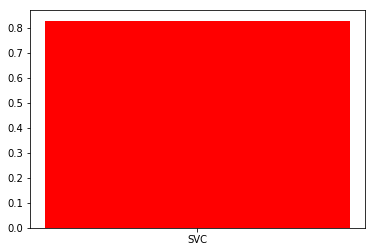

[('SVC', 0.82828256176796344)]


In [51]:
from sklearn.linear_model import LogisticRegression,SGDClassifier,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

base_clfs=[
#     bc,
#     bc.get_nth_model(0),
    bc.get_nth_model(1),
#     SVC(probability=True,random_state=42,C=10.0,gamma=0.01,coef0=1.,degree=3,kernel='poly')
#     GradientBoostingClassifier(learning_rate=0.01,max_depth=5,max_features=None, n_estimators=100)
#     LogisticRegression(random_state=42),
#       SVC(probability=True,random_state=42),
#       RandomForestClassifier(random_state=42),
#       GradientBoostingClassifier(random_state=42),
#       AdaBoostClassifier(), 
#       ExtraTreesClassifier(n_jobs=-1), 
#       XGBClassifier(),
]
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

def trainModels(train_data, target):
    scores=[cross_val_score(clf,train_data,target,scoring='accuracy',cv=5).mean() for clf in base_clfs]

    labels=[c.__class__.__name__[:3] for c in base_clfs]
    X=np.arange(len(base_clfs))
    bar(X,scores,tick_label=labels,color='rgb')
    show()
    print(sorted(zip(labels,scores),key=lambda x:x[1],reverse=True))
    
trainModels(train_data,target)

In [45]:
bc.get_nth_model(1)
# base_clfs[2]

SVC(C=10.0, cache_size=200, class_weight=None, coef0=10.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
TASK_NAME='svc-10-10-0001-poly'
# clf=GradientBoostingClassifier(learning_rate=0.01,max_depth=5,)
# clf.fit(train_data,target)
# bc.select(12)
# clf=bc
# clf=base_clfs[2]
clf=bc.get_nth_model(1)
# clf=GradientBoostingClassifier(learning_rate=0.1,max_depth=3,max_features=None,n_estimators=500,subsample=0.8)
# clf=GradientBoostingClassifier(n_estimators=500)
clf.fit(train_data,target)


SVC(C=10.0, cache_size=200, class_weight=None, coef0=10.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [47]:
# bc.fit_one(2,train_data.values,target)
test_id=passenger_test[id_col]
# clf=base_clfs[0]
survived=clf.predict(test_data)
test_Survived = pd.Series(survived, name="Survived").astype(int)
results = pd.concat([test_id,test_Survived],axis=1)
results.to_csv("output/%s.csv"%TASK_NAME,index=False)